# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

import numpy as np

# TODO: number of training examples
n_train = len(X_train)  # 39209

# TODO: number of testing examples
n_test = len(X_test)  # 12630

# TODO: what's the shape of an image?
image_shape = X_test.shape[1:]   # (32,32,3)

# TODO: how many classes are in the dataset
n_classes = np.max(y_test) - np.min(y_test) + 1     # 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

### Plotting images

A helper function will plot 42 traffic signs in 6 rows and 7 columns. It displays the true class and the predicted class if given.


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_images(images, cls_true, cls_pred=None):
#     assert len(images) == len(cls_true) == 42

    # Create figure with 6x7 sub-plots.
    fig, axes = plt.subplots(6, 7, figsize=(9,10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        if i < len(images):
            ax.imshow(images[i])#.reshape(image_shape))

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "cl: {0}".format(cls_true[i])
            else:
                xlabel = "cl: {0}, pr: {1}".format(cls_true[i], cls_pred[i])

            ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])


The images have 32\*32 pixel dimension, 3 colors and a large spread of quality.  Some of them are very hard to be identified even for humans.  There are many dark images so I've selected a lighter representative of each class (mean pixel value > 130)

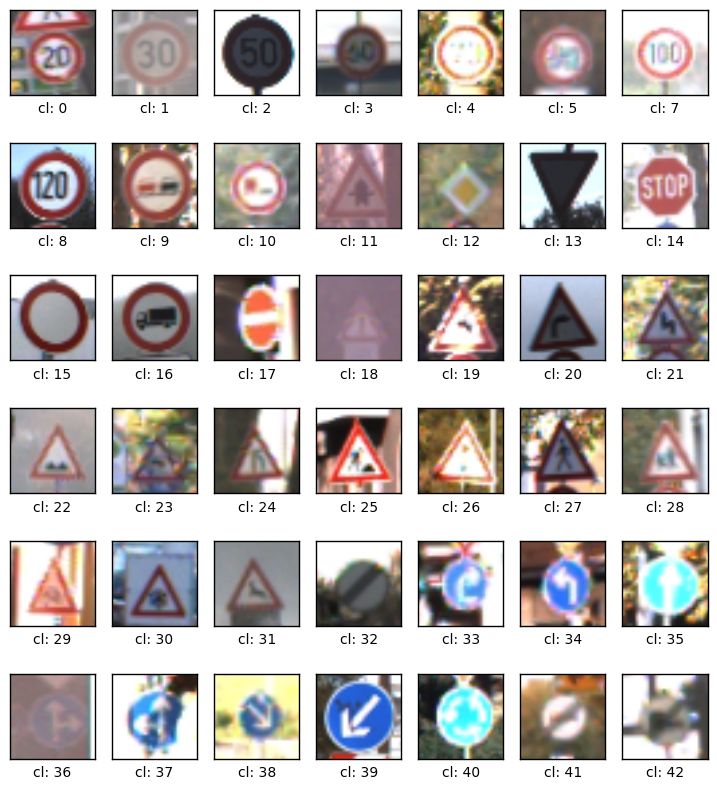

In [5]:
images = []
imgcls = []

for i in range(n_train):
    if np.mean(X_train[i]) > 130 and y_train[i] not in imgcls:
        images.append(X_train[i])
        imgcls.append(y_train[i])


plot_images(images, imgcls)

There are 43 classes in total.  Class 6 is missing from the above enumeration because all samples are very dark.

Let's have a look on the dark side of the class 6, maybe we can catch a lighter sample.

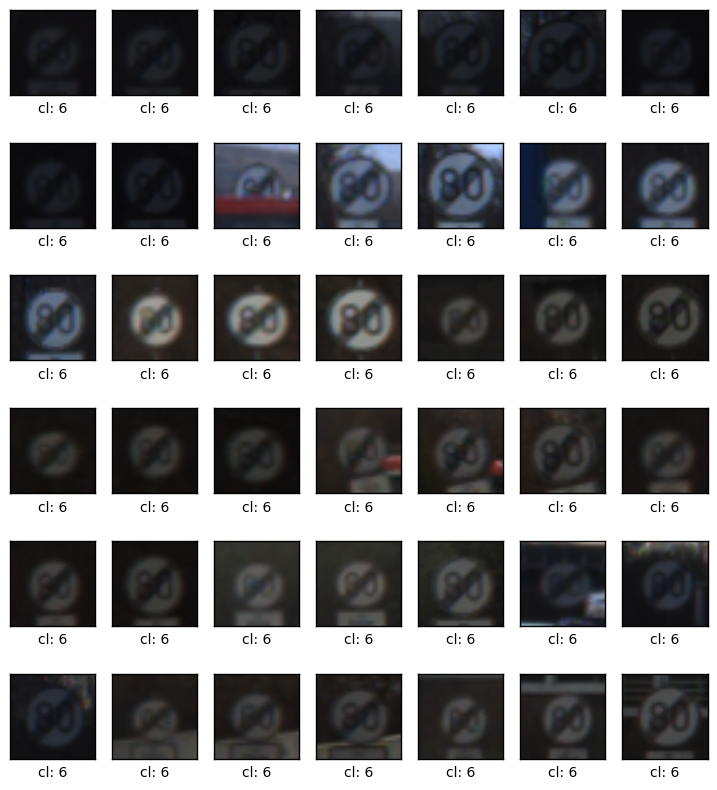

In [6]:
images = []
imgcls = []

for i in range(n_train):
    if y_train[i] == 6:
        images.append(X_train[i])
        imgcls.append(y_train[i])


plot_images(images[:420:10], imgcls[:420:10])


These images are  very dark.  Let's try to normalize the images and to transform the pixels of 0..255 integers to 0..1 float range.

### Normalize

In [26]:
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.01, 0.99]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.01
    b = 0.99
    norm_img = []
    for img in image_data:
        x_min = np.min(img)
        x_max = np.max(img)
        norm_img.append(a + (img - x_min) * (b - a) / (x_max - x_min))
    return np.array(norm_img)

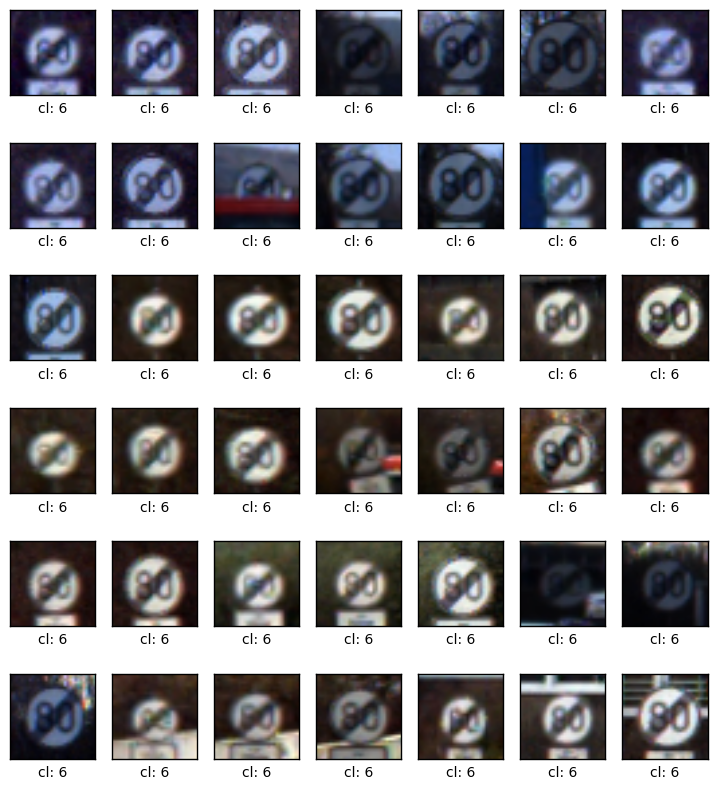

In [8]:
plot_images(normalize(images[:420:10]), imgcls[:420:10])

After normalization almost all traffic signs of the above sample can be identified.

I do hope if humans can distinguish more clearly these traffic signs then this will help the classification by the computer as well.

Let's normalize all training and testing features.

In [9]:
X_train = normalize(X_train)
X_test = normalize(X_test)
# Change to float32, we're working with float32 in tf
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

print('Features normalized on 0.01 - 0.99 scale')

Features normalized on 0.01 - 0.99 scale


### One-Hot-Encoding

Let's apply one-hot-encoding on training and test labels.

In [10]:
# Turn labels into numbers and apply One-Hot Encoding
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against 
# the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


### Radnomize order

Training data is ordered in increasing classes.  It is a good idea to randomize the order.

In [11]:
# put training data in randomized order
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

print('Training features and labels are randomized.')

Training features and labels are randomized.


### Save data

In [12]:
# Save the data for easy access
import os

pickle_file = 'traf_sign_norm_rand_1hot.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'X_train': X_train,
                    'y_train': y_train,
                    'X_test': X_test,
                    'y_test': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Loading data

Preprocessing of data has been done in previous steps and it has been saved in a pickle file.  In this step we have the opportunity to load the preprocessed data.

In [1]:
# Load the modules
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

import numpy as np
import tensorflow as tf
from tqdm import tqdm


In [2]:


# Reload the data
pickle_file = 'traf_sign_norm_rand_1hot.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['X_train']
    y_train = pickle_data['y_train']
    X_test = pickle_data['X_test']
    y_test = pickle_data['y_test']
    del pickle_data  # Free up memory


print('Training and testing data is loaded.')

Training and testing data is loaded.


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

### Warm-up procedure: Simple linear model

Let's try to classify the data with a simple linear model in the first step, to have a base case and to see what might be expected on later experiments.

The example from CarND-TensorFlow-Lab has been adapted for traffic signs with 32\*32 pixels and RGB colors.

In [8]:
# neural network with 1 layer of 43 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 3072]        # 32*32*3
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [3072, 43]     b[43]
#   · · · · · · · ·                                              Y [batch, 43]


# input X: 32*32 color images, the first dimension (None) is the batch size
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
# label - true Y
Y_ = tf.placeholder(tf.float32, [None, 43])
# weights W[3072, 43]  # 32*32*3
W = tf.Variable(tf.zeros([3072, 43]))
# biases b[43]
b = tf.Variable(tf.zeros([43]))

# flatten the images into a single line of pixels
# -1 in the shape definition means "preserve the number of elements"
XX = tf.reshape(X, [-1, 3072])   # [batch,3072]

# Linear Function XW + b
logits = tf.matmul(XX, W) + b    # [batch,3072] x [3072,43] = [batch,43]

# Y - computed prediction
Y = tf.nn.softmax(logits)        # [batch,43]

# cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_)  # [batch]
# Training loss
loss = tf.reduce_mean(cross_entropy)

# accuracy of the trained model
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))       # [batch]
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))     # scalar [0..1]

print('Accuracy function created.')


Accuracy function created.


Epoch 10/10: 100%|██████████| 130/130 [00:04<00:00, 27.16batches/s]


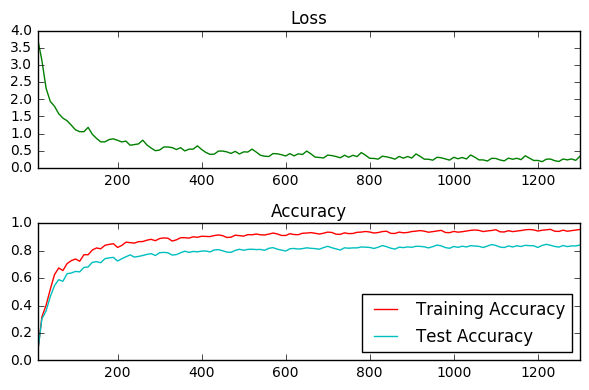

Epochs = 10
learning_rate = 0.003
Test accuracy at 0.8421224355697632


In [9]:

epochs = 10
batch_size = 300
learning_rate = 0.003

# AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# init
init = tf.initialize_all_variables()
session = tf.Session()
session.run(init)

# Measurements use for graphing loss and accuracy
log_batch_step = 10
batches = []
loss_batch = []
train_acc_batch = []
test_acc_batch = []

batch_count = int(len(X_train)/batch_size)

for epoch_i in range(epochs):

    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')

    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        X_batch = X_train[batch_start:batch_start + batch_size]
        y_batch = y_train[batch_start:batch_start + batch_size]

        # Run optimizer and get loss
        _, l = session.run(
            [optimizer, loss],
            feed_dict={X: X_batch, Y_: y_batch})

        # Log every after log_batch_step batches
        if batch_i % log_batch_step == 0:
            # Calculate Training and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict={X: X_train, Y_: y_train})
            test_accuracy = session.run(accuracy, feed_dict={X: X_test, Y_: y_test})

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            test_acc_batch.append(test_accuracy)

# Check test accuracy 
test_accuracy = session.run(accuracy, feed_dict={X: X_test, Y_: y_test})

session.close()

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, test_acc_batch, 'c', label='Test Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc='best')
plt.tight_layout()
plt.show()

print('Epochs =', epochs)
print('learning_rate =', learning_rate)
print('Test accuracy at {}'.format(test_accuracy))


I think this is about the maximum what we can squeze out of a simple linear logistic model.  The first GradientDescentOptimizer experiments gave accuracy around 0.6 but with AdamOptimizer and some more parameter tuning this could be improved to an accuracy above 0.8

In [10]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

Since we are scarce on data I decided to not use validation set.  The training data and the testing data is the original one:

Number of training examples = 39209  
Number of testing examples = 12630  
Image data shape = (32, 32, 3)  
Number of classes = 43  

The training and testing image data has been normalized becuase some of the images were very dark.  The testing data has been shuffled because originally it was ordered according to the class labels.

I've decided to not generate additional data.  Since I have limited time for this project I speculated that I can gain more by trying to build several neural networks with tensorflow than by manipulating image data.

My second experiment was to transform my simple linear model to Deep Neural Network - by adding two more layers.

### Deep Dive into DNN: 2 layer sigmoid + 1 layer softmax

Since we maxed out our possibilites with simple neural network I've added 2 more sigmoid layers.  Here is the implementation and the results:

In [11]:
#tf.set_random_seed(42)

# neural network with 2 layer sigmoid + 1 layer of 43 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 3072]        # 32*32*3
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (sigmoid)      W1 [3072, K]     B1[K]
#    · · · · · · ·                                               Y1 [batch, K]
#    \x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [K, L]     # B2[L]
#    · · · · · · ·                                               Y2 [batch, L]
#      \x/x\x/           -- fully connected layer (softmax)      W3 [L, 43]     # B3[43]
#   · · · · · · · ·                                              Y [batch, 43]

# 2 deep layer
K = 800
L = 200

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 43])
# variable learning rate
lr = tf.placeholder(tf.float32)

# Weights initialised with small random values between -0.2 and +0.2
# When using RELUs, make sure biases are initialised with small *positive* values for example 0.1 = tf.ones([K])/10
W1 = tf.Variable(tf.truncated_normal([3072, K], stddev=0.1))  # 28 * 28 * 3
B1 = tf.Variable(tf.zeros([K]))
W2 = tf.Variable(tf.truncated_normal([K, L], stddev=0.1))
B2 = tf.Variable(tf.zeros([L]))
W3 = tf.Variable(tf.truncated_normal([L, 43], stddev=0.1))
B3 = tf.Variable(tf.zeros([43]))



# The model
XX = tf.reshape(X, [-1, 3072])
Y1 = tf.nn.sigmoid(tf.matmul(XX, W1) + B1) # [batch,3072]x[3072,K] = [batch,K]
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2) + B2) # [batch,K]x[K,L] = [batch,L]
logits = tf.matmul(Y2, W3) + B3           # [batch,L]x[L,43] = [batch,43]
Y = tf.nn.softmax(logits)                 # prediction [batch,43]

# loss function: cross-entropy = - sum( Y_i * log(Yi) )
#                           Y: the computed output vector
#                           Y_: the desired output vector
# cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_)  # [batch]
# Training loss
loss = tf.reduce_mean(cross_entropy)

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


Epoch 10/10: 100%|██████████| 130/130 [00:05<00:00, 25.49batches/s]


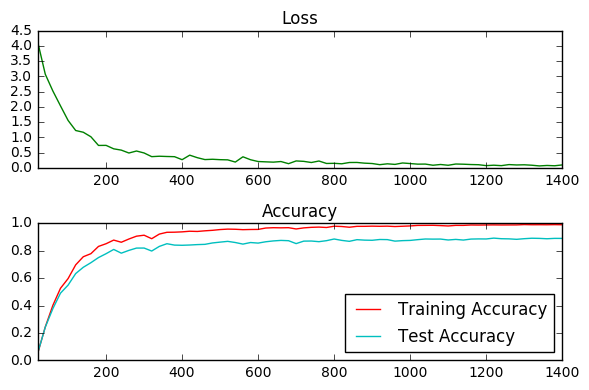

Epochs = 10
learning_rate = 0.002
Test accuracy at 0.8864612579345703


In [12]:
epochs = 10
batch_size = 300
learning_rate = 0.002

# AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# init
init = tf.initialize_all_variables()
session = tf.Session()
session.run(init)

# Measurements use for graphing loss and accuracy
log_batch_step = 20
batches = []
loss_batch = []
train_acc_batch = []
test_acc_batch = []

batch_count = int(len(X_train)/batch_size)

for epoch_i in range(epochs):

    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')

    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        X_batch = X_train[batch_start:batch_start + batch_size]
        y_batch = y_train[batch_start:batch_start + batch_size]

        # compute loss & optimize
        l, _ = session.run( [loss, optimizer],
                           feed_dict={X: X_batch, Y_: y_batch, 
                                      lr: learning_rate * ((epochs - epoch_i)/epochs)})

        # Log every after log_batch_step batches
        if batch_i % log_batch_step == 0:
            # Calculate Training and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict={X: X_train, Y_: y_train})
            test_accuracy = session.run(accuracy, feed_dict={X: X_test, Y_: y_test})

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            test_acc_batch.append(test_accuracy)

# Check test accuracy
test_accuracy = session.run(accuracy, feed_dict={X: X_test, Y_: y_test})
session.close()

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, test_acc_batch, 'c', label='Test Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc='best')
plt.tight_layout()
plt.show()

print('Epochs =', epochs)
print('learning_rate =', learning_rate)
print('Test accuracy at {}'.format(test_accuracy))


The addition of the two sigmoid layers got us an extra 4% accuracy.  Adding more layers unfortunately doesn't bring us more gain.  This is because our neural network outgrows the amount of disponible data and we end up overfitting the training data and we loose on test data accuracy.  The only trick what helped somewhat was applying a small decay to the learning rate.  AdamOptimizer has built-in control of the learning rate but the experience shows that we could give him some outside help.  Since our neural network is quite simple the regularization didn't had a significant effect.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Final Architecture: 3 Layer CNN relu + 2 Layer fully connected sigmoid + 1 Layer softmax

This is how we arrived to our final architecture by adding 3 more layers of CNN with relu activation function.  The first CNN layer has as input the 3 color layers (R,G,B), is scanning a 6x6 square and has an output of 18 channels.  The next CNN is scanning a 5x5 square, output channels are doubled (36 channels) and has a stride of [2,2] (image sizes are reduced to 16x16 pixels).  The last CNN is scanning a 4x4 square, output channels are doubled again (72 channels) and stride of [2,2] reduces image sizes to 8x8 pixels.  The images from the last CNN layer are flattened out before going to the two fully connected sigmoid layers with regularization and finally evalutaed in the softmax activation.

In [12]:
# neural network structure 3 * cnn + 2 * sigmoid + 1 * softmax:
#
# · · · · · · · · · ·      (input data, 3-deep(color))           X [batch, 32, 32, 3]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer 6x6x3=>18 stride 1        W1 [6, 6, 3, 18]        B1 [18]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                            Y1 [batch, 32, 32, 36]
#   @ @ @ @ @ @ @ @     -- conv. layer 5x5x18=>36 stride 2       W2 [5, 5, 18, 36]       B2 [36]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶                                              Y2 [batch, 16, 16, 36]
#     @ @ @ @ @ @       -- conv. layer 4x4x36=>72 stride 2       W3 [4, 4, 36, 72]       B3 [72]
#     ∶∶∶∶∶∶∶∶∶∶                                                Y3 [batch, 8, 8, 72] => reshaped to YY [batch, 8*8*72]
#      \x/x\x\x/        -- fully connected layer (sigmoid)       W4 [8*8*72, 800]        B4 [800]
#       · · · ·                                                  Y4 [batch, 800]
#       \x/x\x/         -- fully connected layer (sigmoid)       W5 [800, 200]           B5 [200]
#       · · · ·                                                  Y5 [batch, 200]
#        \\x//          -- fully connected layer (softmax)       W6 [200, 43]            B6 [43]
#        · · ·                                                   Y [batch, 43]

tf.set_random_seed(3333)

# input X: 32*32 color images, the first dimension (None) will index the images
# in the mini-batch
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 43])
# variable learning rate
lr = tf.placeholder(tf.float32)
# Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.6 at training time
pkeep = tf.placeholder(tf.float32)

# three convolutional layers with their channel counts, and a
# fully connected layer (tha last layer has 43 softmax neurons)
K = 18   # first convolutional layer output depth
L = 36   # second convolutional layer output depth
M = 72   # third convolutional layer
N = 800  # fully connected layer
O = 200  # fully connected layer

# relu Bias needs to be initialized to a small number > 0
W1 = tf.Variable(tf.truncated_normal([6, 6, 3, K], stddev=0.1))  # 6x6 patch, 3 input channel, K output channels (32)
B1 = tf.Variable(tf.ones([K])/22)
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))  # 5x5 patch, K input channel, L output channels (64)
B2 = tf.Variable(tf.ones([L])/22)
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))  # 4x4 patch, L input channel, M output channels (128)
B3 = tf.Variable(tf.ones([M])/22)
W4 = tf.Variable(tf.truncated_normal([8 * 8 * M, N], stddev=0.1))  # fully conn [8*8*M,N] -> (3072,800)
B4 = tf.Variable(tf.zeros([N]))
W5 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))        # fully conn [N, O]  [800,200]
B5 = tf.Variable(tf.zeros([O]))
W6 = tf.Variable(tf.truncated_normal([O, 43], stddev=0.1))       # fully conn [O, 43] -> (200,43)
B6 = tf.Variable(tf.zeros([43]))


# The model
stride = 1  # output is 32*32
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)  #[batch, 32, 32, 36]
stride = 2  # output is 16*16
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 8*8
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 8 * 8 * M])   # [batch, 3072]

Y4 = tf.nn.sigmoid(tf.matmul(YY, W4) + B4)
Y4d = tf.nn.dropout(Y4, pkeep)
Y5 = tf.nn.sigmoid(tf.matmul(Y4d, W5) + B5)
Y5d = tf.nn.dropout(Y5, pkeep)

Ylogits = tf.matmul(Y5d, W6) + B6
Y = tf.nn.softmax(Ylogits)
Y_top5 = tf.nn.top_k(Y, k=5, sorted=True)  # result evaluation

# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_)
cross_entropy = tf.reduce_mean(cross_entropy)


# Training loss
loss = tf.reduce_mean(cross_entropy)

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

During my previous experiments with simple model I've got a good sense of preferred parameter range.  E.g. batch size of 300 is one of my favourites.  Once I established it I didn't bother to tune it further.  Insted a made up a theory: since we have 43 classes it is preferred to have a balanced distribution of the classes in every batch and a size of 300 samples gives us a fair equilibrum between balance and performance.  

In my previous experiments I've used 10 epochs but this model is more evolved, here after 5 epochs we reach saturation.  Learning rate and regularization probability (pkeep) has been choosen based on previous and current experiments.  AdamOptimizer gave me significantly better results than GradientDescentOptimizer, it even helps to control the learning rate so it was an obvious choice.  Here is the result:

Epoch  5/5: 100%|██████████| 130/130 [00:26<00:00,  7.44batches/s]


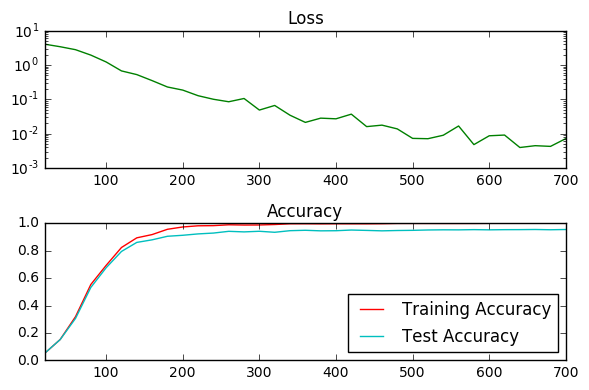

epochs = 5
batch_size = 300
learning_rate = 0.003
pkeep = 0.6
regularization_fix = 12
Last Test accuracy: 0.9533796310424805
Max Test accuracy: 0.9542796611785889


In [13]:
pk = 0.6
epochs = 5
batch_size = 300
learning_rate = 0.003
regularization_fix = 12

# AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# saver
# saver = tf.train.Saver()

# init
init = tf.initialize_all_variables()
session = tf.Session()
session.run(init)

# Measurements use for graphing loss and accuracy
log_batch_step = 20
batches = []
loss_batch = []
train_acc_batch = []
test_acc_batch = []

batch_count = int(len(X_train)/batch_size)

for epoch_i in range(epochs):

    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')

    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        X_batch = X_train[batch_start:batch_start + batch_size]
        y_batch = y_train[batch_start:batch_start + batch_size]

        # compute loss
        l = session.run(loss,
            feed_dict={X: X_batch, Y_: y_batch, pkeep: 1.0})

        # fixing regularization
        tf.set_random_seed(((epoch_i*batch_count)+batch_i)%regularization_fix)

        # optimize parameters
        _ = session.run(optimizer,
            feed_dict={X: X_batch, Y_: y_batch, pkeep: pk,
                       lr: learning_rate * ((epochs - epoch_i)/epochs)})

        # Log every [step] batches
        if batch_i % log_batch_step == 0:
            # Calculate Training and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict={X: X_train[:11111],
                                                                 Y_: y_train[:11111], pkeep: 1.0})
            test_accuracy = session.run(accuracy, feed_dict={X: X_test[:11111], Y_: y_test[:11111], pkeep: 1.0})

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            test_acc_batch.append(test_accuracy)
#    print('\n','test_accuracy=',test_accuracy)

test_accuracy = session.run(accuracy, feed_dict={X: X_test[:11111], Y_: y_test[:11111], pkeep: 1.0})

# checkpoint save
# saver.save(session, '3cnn_2sigmoid_1softmax2.ckpt') # 1: 957, 3: 956, 2:955
# session.close()

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
loss_plot.set_yscale('log')
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, test_acc_batch, 'c', label='Test Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc='lower right')
plt.tight_layout()
plt.show()

print('epochs =', epochs) # 33
print('batch_size =',batch_size) # 300
print('learning_rate =',learning_rate) # 0.0005
print('pkeep =', pk)
print('regularization_fix =',regularization_fix)
print('Last Test accuracy: {}'.format(test_accuracy))
print('Max Test accuracy: {}'.format(np.max(test_acc_batch)))


In [14]:
#session.close()  # we don't close yet the session, we are going to use the trained network

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I've watched the Udacity lessons and I've checked a few more tensorflow and CNN tutorials on the web.  I've tried to replicate the "standard" CNN implementation.  I've had to consider my notebooks limits (GeForce GTX 960M) - e.g. evaluation training and testing accuracy can't be done on the whole training and testing dataset because I've got "Resource Exhausted Error".  The only way to get around this was to limit the dataset amount or to reduce the complexity of my network.  I wanted the best network what can be trained on my notebook, therefore the dataset has been limited to ~11,111 datapoints - but this amoount is almost the whole testing data - so this is not affecting the end results.

I am seeding several times the tf randomization and most of the times the test accuracy is around 95% but there remains some randomization which I couldn't control.  I've applied a randomization seed to the regularization as well to make my test accuracy function converge smoother.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

Lets read *signnames.csv* into cl_txt dictionary to have a proper class - text conversion.

In [15]:
cl_txt = {}
with open('signnames.csv') as f:
    f.readline() # header line
    for line in f.readlines():
        line = line.strip()   # strip linefeed
        cl, txt = line.split(',')
        cl_txt[int(cl)] = txt
print('Traffic sign class-text conversion loaded')

Traffic sign class-text conversion loaded


The subroutine *display_logits* is going to display the image and the corresponding logits.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

def display_logits(idx, img_data, y_top5, y_true_lst):
    """ 
    display image and associated logits
    img_data, y_top5 and y_true_lst are arrays, 
    idx is the index which should be displayed.
    """
    true_cl = y_true_lst[idx]
    img = img_data[idx]
    logits_val = list(y_top5[0][idx])
    logits_class = list(y_top5[1][idx])
    logits_class = list(map(lambda x: int(x), logits_class)) # float -> int

    fig = plt.figure(figsize=(10,2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

    # img display
    ax0 = plt.subplot(gs[0])
    ax0.imshow(img)
    # remove ticks
    ax0.set_xticks([])
    ax0.set_yticks([])

    # logits bar display
    ax1 = plt.subplot(gs[1])
    bar_display_index = [4,3,2,1,0]
    bar_width = 0.64
    opacity = 0.55

    rects = ax1.barh(bar_display_index, logits_val, bar_width,
                     alpha=opacity, color='r', label='logits_val')

    for ii,rect in enumerate(rects):
        height = rect.get_height()
        width = rect.get_width()
        y = rect.get_y()
        text = ' {:5.2f}%  cl:{:2d},  "{:s}"'.format(width*100,
                                    logits_class[ii], cl_txt[logits_class[ii]])
        plt.text(1.1, y+height/2, text, ha='left', va='center')
        if logits_class[ii] == true_cl:
            rect.set_color('g')
            plt.text(1.1,y + height/2, text, ha='left', va='center',
                                         bbox={'facecolor':'green', 'alpha':0.5})

    plt.xlim(0,6)
    # remove ticks
    ax1.set_xticks([0, 0.5, 1])
    ax1.set_yticks([])
    plt.tight_layout()
    plt.show()


### Visualising the Test Data

Before going out into the wild let's have a look on our test data.  Let's make a prediction for the first 200 test images.

In [41]:
y_top5, y_pred, y_pred_correct = session.run([Y_top5, Y, correct_prediction],
                                       feed_dict={X: X_test[:200], Y_: y_test[:200], pkeep: 1.0})
y_true = y_test[:200]  # one hot encoded
y_true_lst = np.argmax(y_true, axis=1)  # y_true list of integers

Now let's have a look on the first 10 images and visualise the logits distribution.

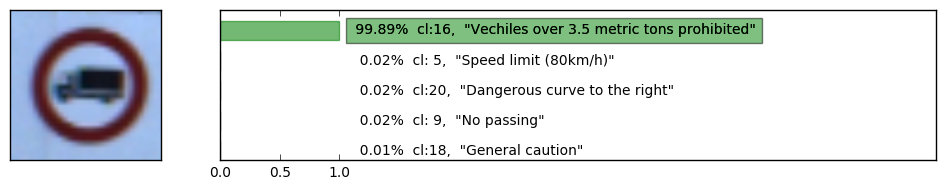

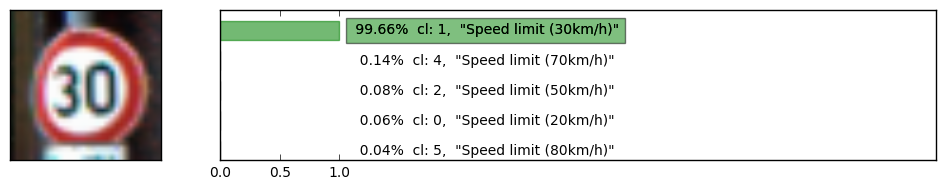

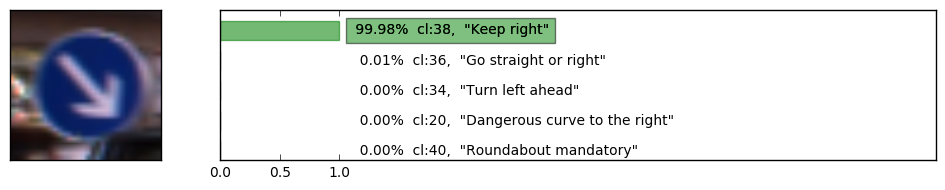

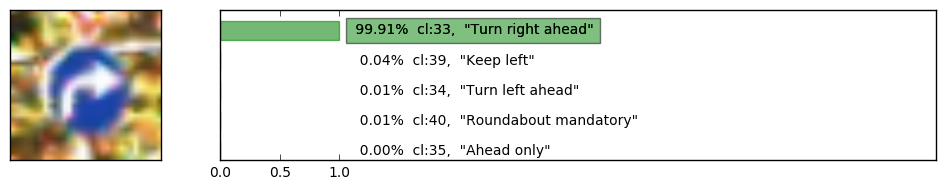

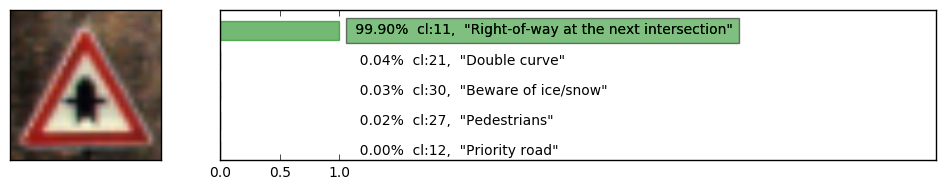

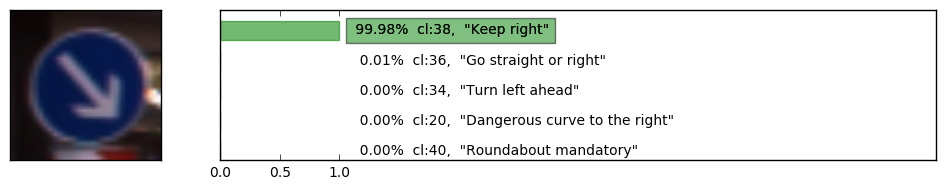

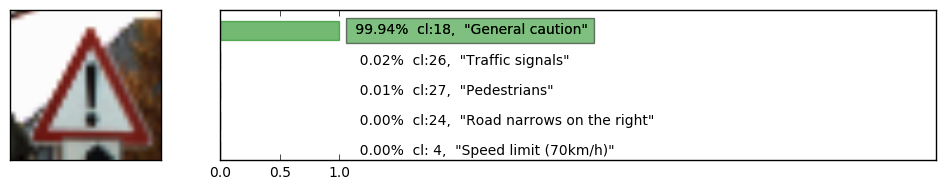

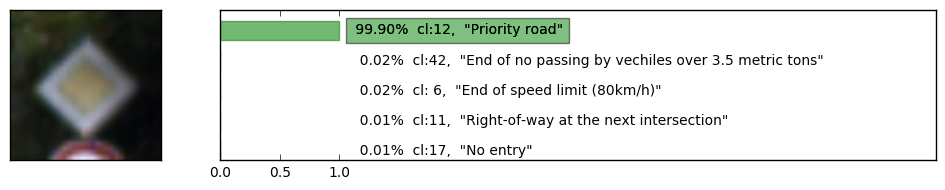

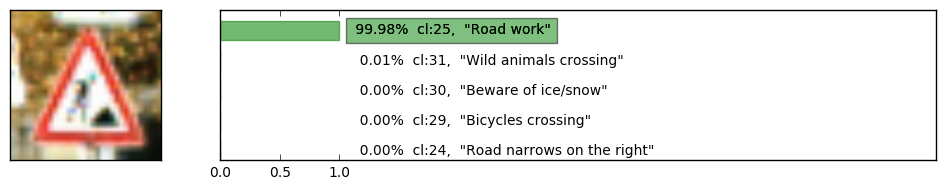

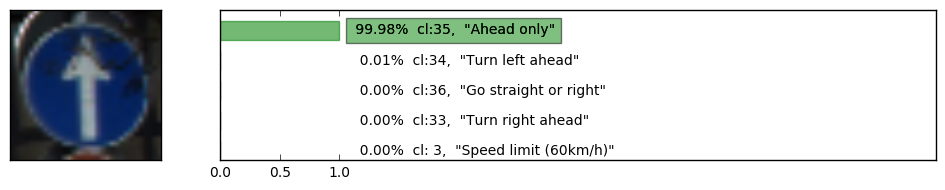

In [19]:
for idx in range(10):
    display_logits(idx, X_test, y_top5, y_true_lst)

This looks quite nice.  It seems that most of the time is 99% sure of the right traffic sign.

### Visualising missed test data

Now let's take a look on those test samples where we couldn't guess the right traffic sign.

In [21]:
missed_pred_idxs = np.where(y_pred_correct == False)[0]
print('There are {} traffic signs missed in the first 200 test datapoints'.format(len(missed_pred_idxs)))

There are 9 traffic signs missed in the first 200 test datapoints


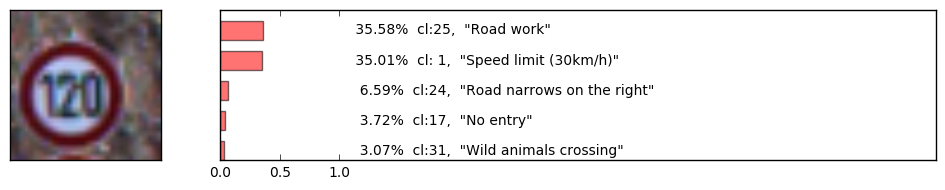

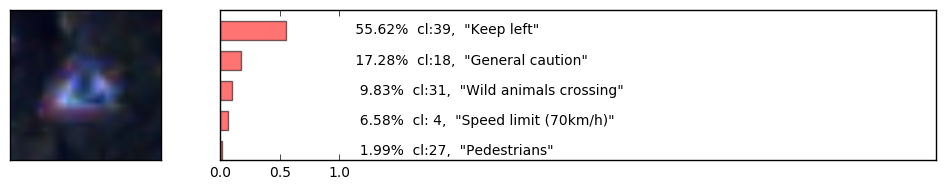

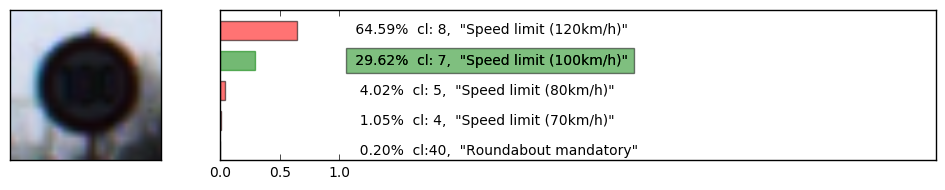

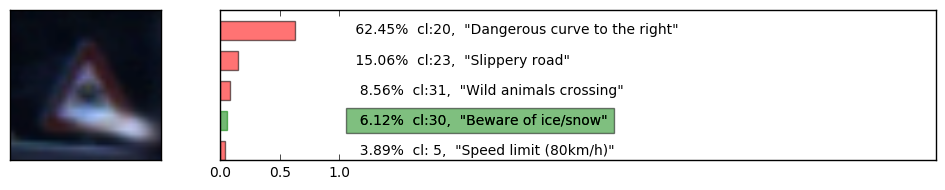

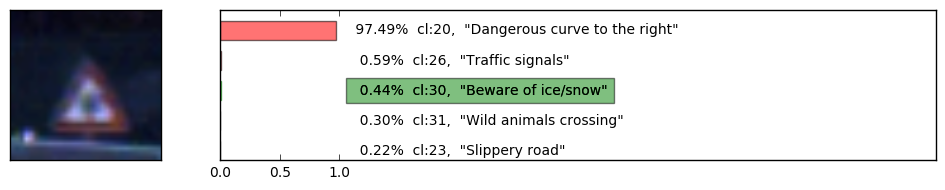

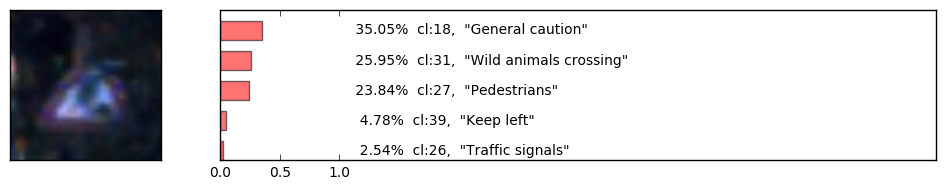

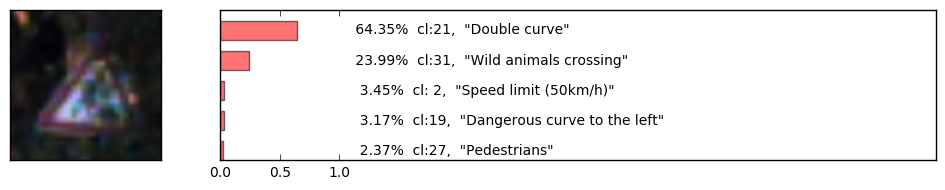

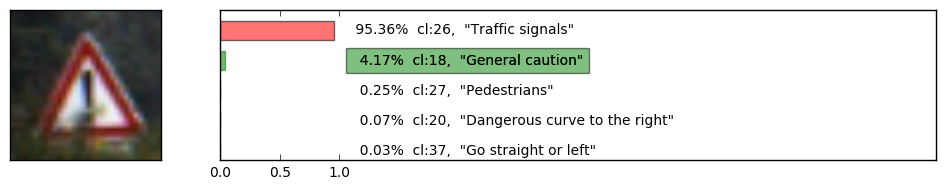

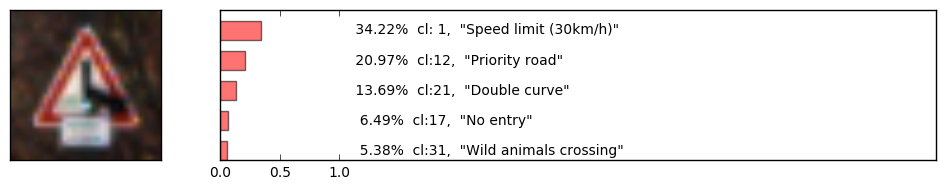

In [22]:
for idx in missed_pred_idxs:
    display_logits(idx, X_test, y_top5, y_true_lst)

The first speed limit 120 looks like a big miss, but if we look more carefully we can see that the traffic sign is somewhat smaller than usual, is not in the center and probably the background has contributed as well to make it unrecognizable by our network.  

The rest of the mistakes can be attributed mostly to very poor image quality, but we still have 4 images which have a hit in the first 5 logits.

The last but one "General caution" is an interresting miss.  The are some green leaves in front of the dot of the exclamation sign and this green patch made our neural network to "think" that this is rather a "Traffic signals", so the "General caution" came only as a second guess.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

There are 20 images which have similar shapes to the classes used in our model - for these images I provided the y_true class in value range [0..42]  
There are 14 images which are more or less different from images used in our model - for these I provide value -1 as true class label.

Loading of the images is done via the subroutine described in Q9.

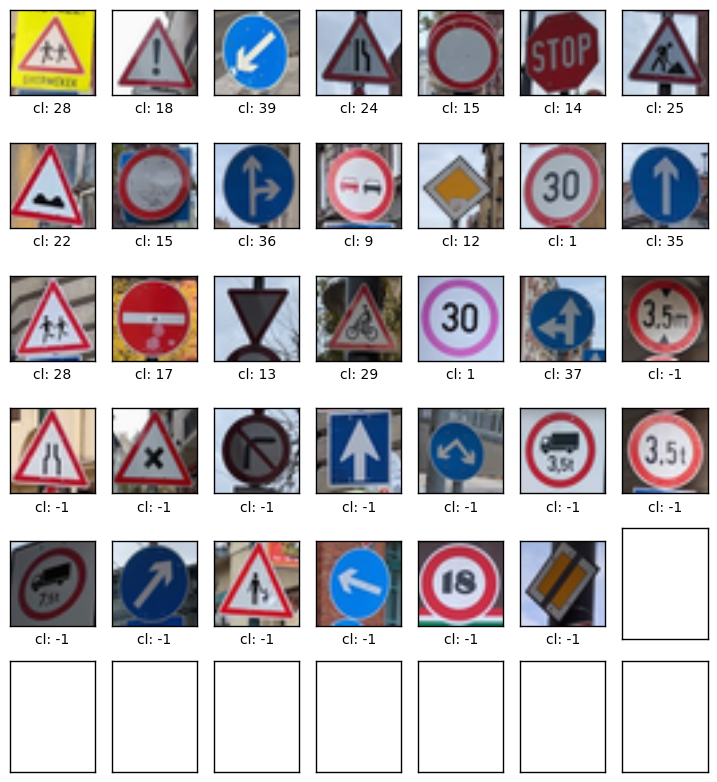

In [50]:
x_test0, y_true_lst0 = my_img_load('my_img')
x_test1, y_true_lst1 = my_img_load('my_img1')
x_test = np.append(x_test0, x_test1, axis=0)
y_true_lst = y_true_lst0 + y_true_lst1
plot_images(x_test, y_true_lst)

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [42]:
y_top5, y_pred = session.run([Y_top5, Y], feed_dict={X: x_test, pkeep: 1.0})


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Let's have a look first on images which have corresponding traffic classes in our model.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

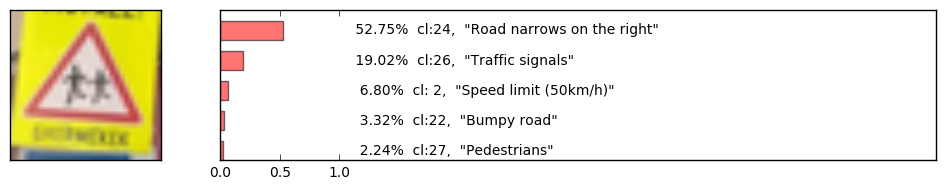

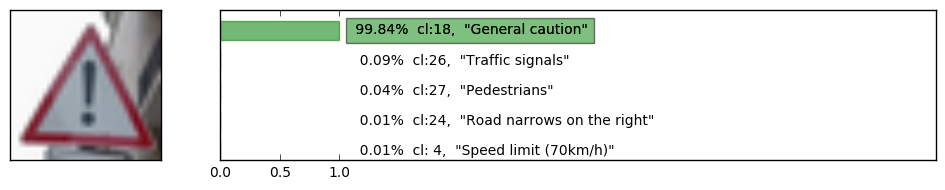

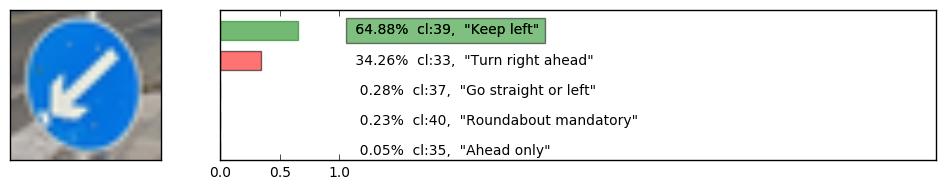

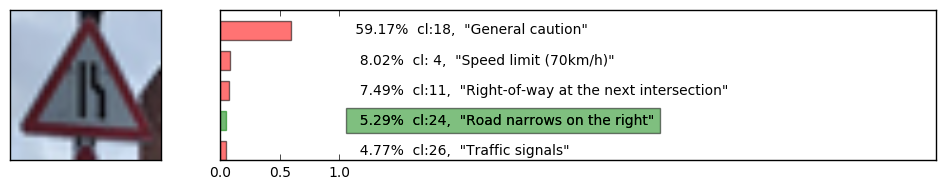

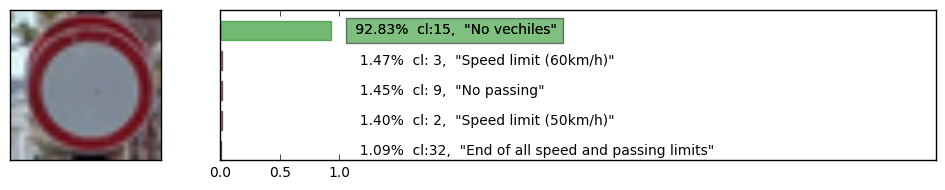

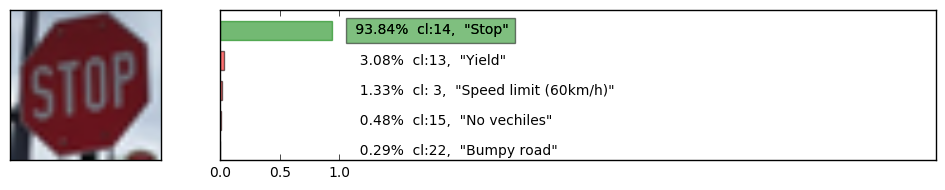

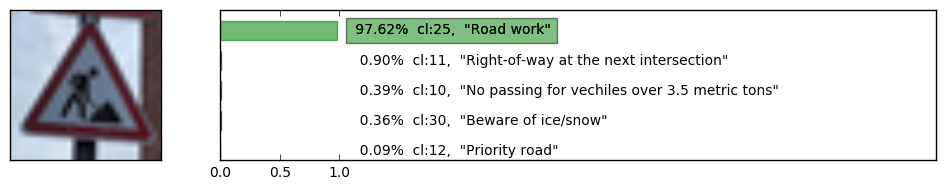

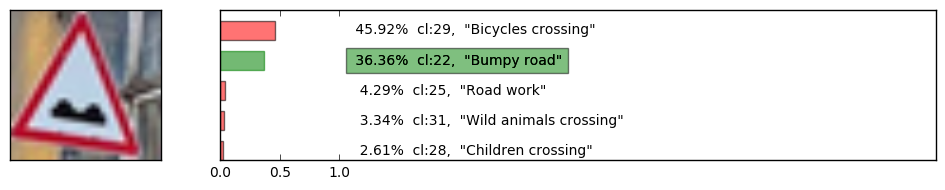

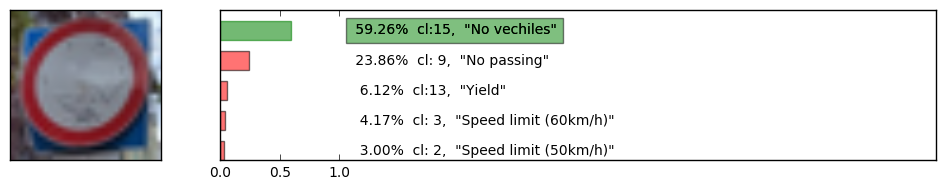

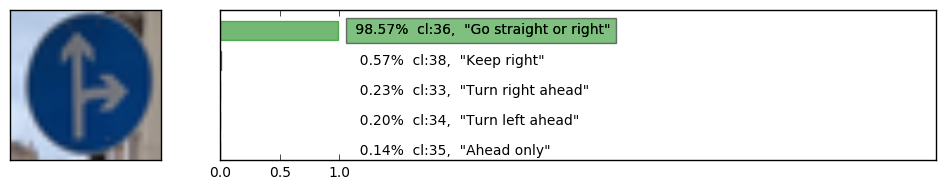

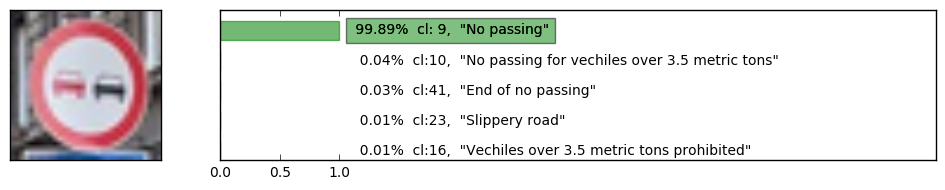

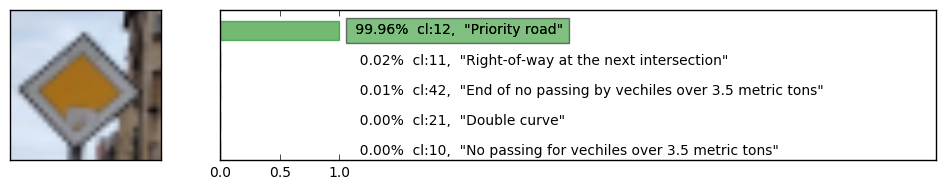

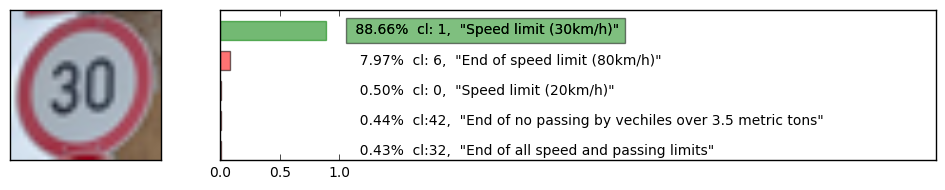

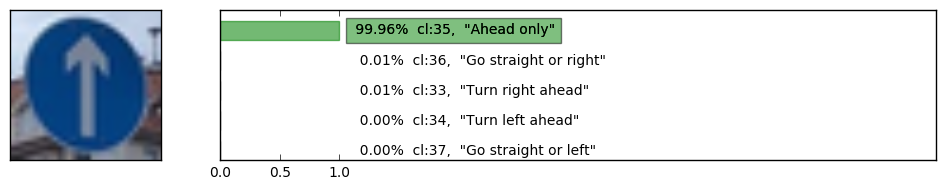

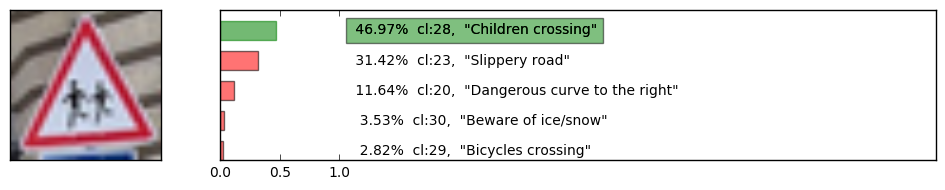

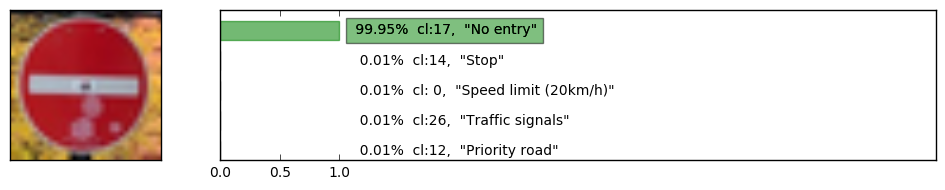

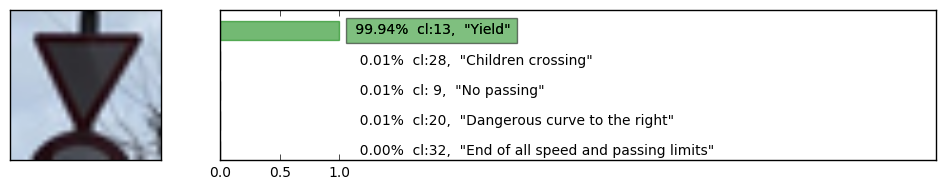

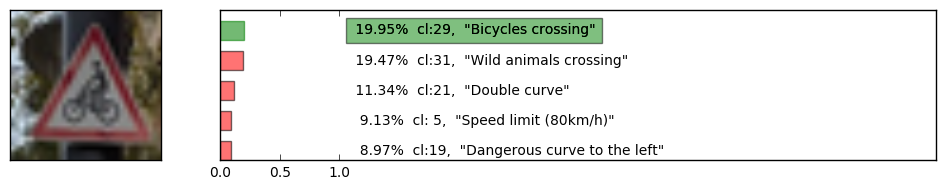

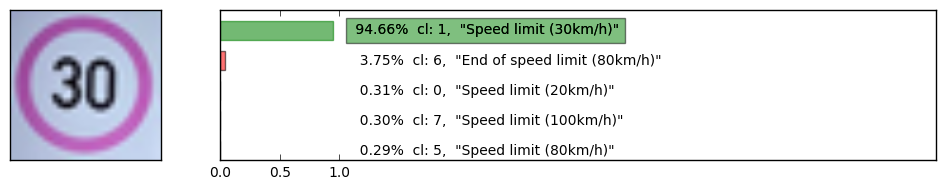

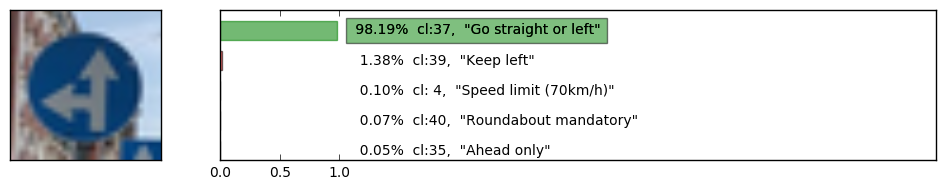

In [49]:
for idx in range(20):
    display_logits(idx, x_test, y_top5, y_true_lst)
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

We have a success rate of 17 out of 20 traffic signs.  This is a small sample but it suggests that my images are somehow different from the images used to train and to test our model.  However it is a good indication that in two cases the correct prediction appears in the top5 predictions.

### Just for fun

Let's take a look on the predictions of traffic signs which are not exactly the same we used for training or are completely different from those.

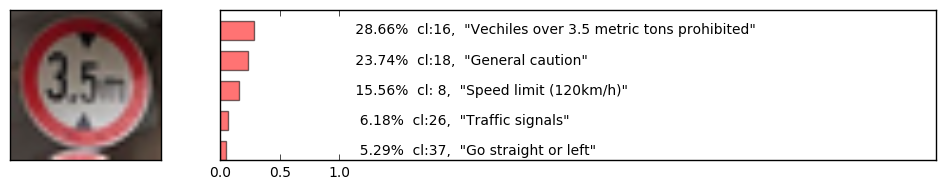

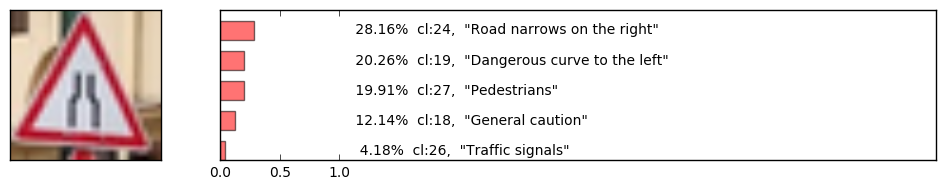

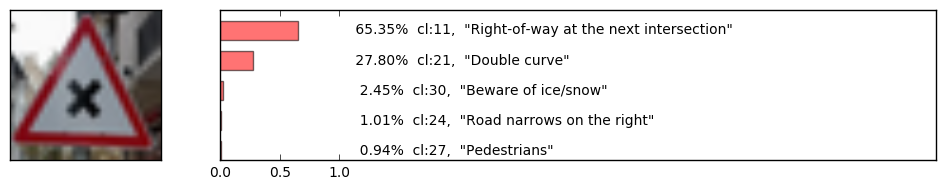

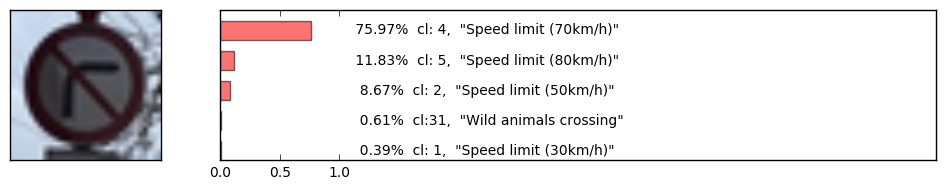

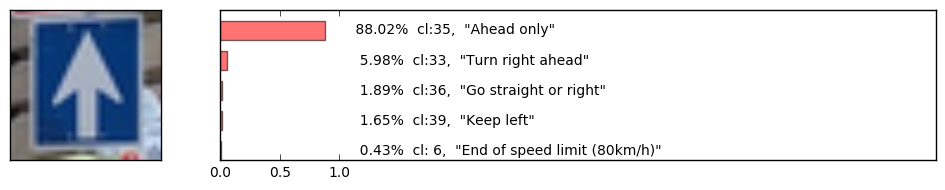

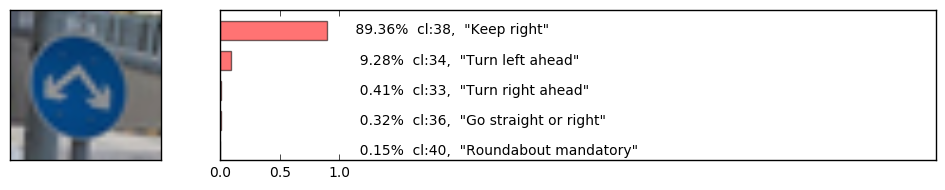

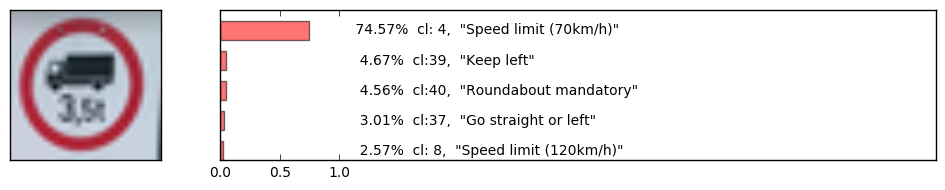

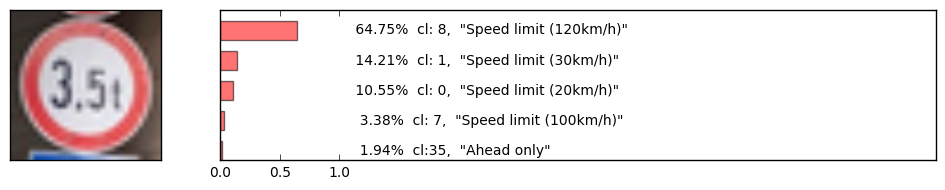

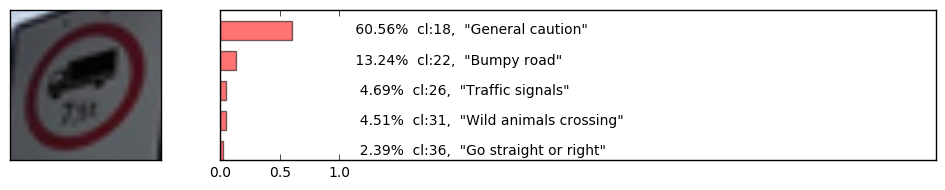

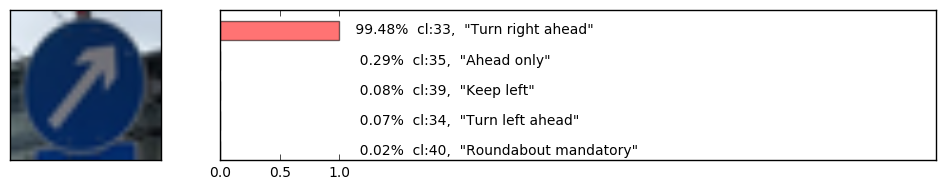

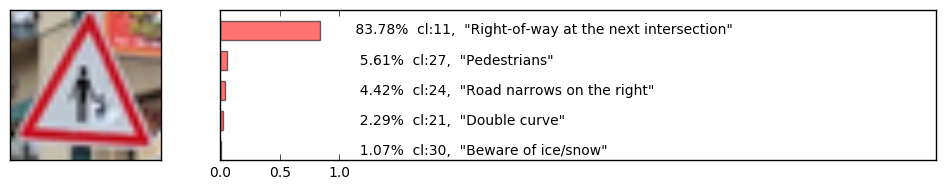

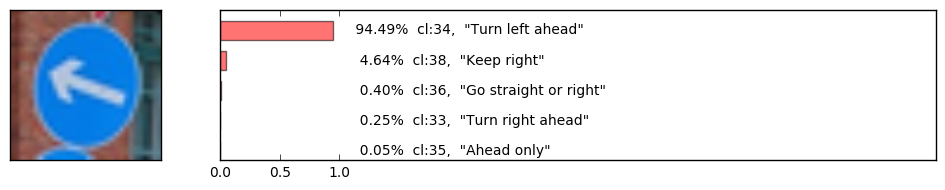

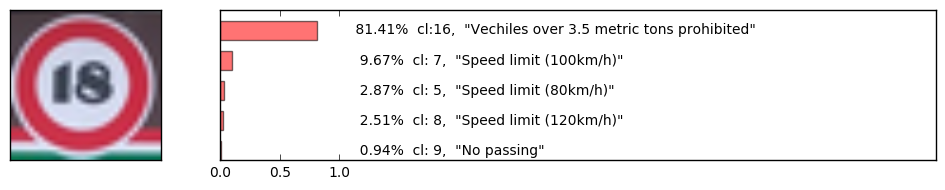

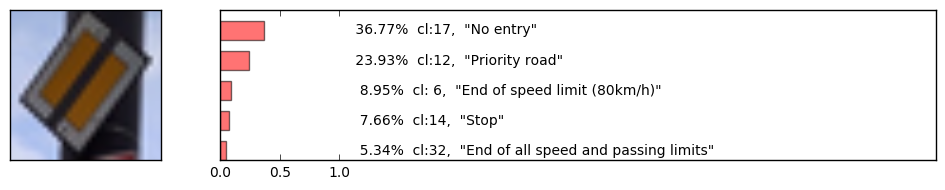

In [51]:
for idx in range(20,34):
    display_logits(idx, x_test, y_top5, y_true_lst)


We can see on the images above that in a red circle there can be written many things and for us humans it is easy to interpret them, but the computer has problems with these, it has to be trained for every single string what might occur on these traffic signs.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

In the directory 'my_img' are stored 20 images taken by me in the neighborhood.  These traffic signs have corresponding classes in our model.  In the directory 'my_img1' are stored images of traffic signs which havo no corresponding traffic classes or the sign is somewhat different.  The images are loaded with *my_img_load()* subroutine.

In [23]:
from scipy import misc
import glob
def my_img_load(directory):
    img_data = []
    y_true_lst = []
    for f in glob.glob(directory + '/*'):
        img = misc.imread(f)
        img_data.append(img)
        if f.startswith('my_img/'):
            cl = int(f[7:9])
        else:
            cl = -1
        y_true_lst.append(cl)
    x_test = normalize(img_data)
    return x_test, y_true_lst


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.